In [3]:
import pandas as pd
import time
import threading
from tqdm import tqdm
from binance.client import Client

client = Client()

### All tradable assets in this dictionnary

In [3]:
info = client.get_exchange_info()

In [9]:
symbols = [x['symbol'] for x in info['symbols']]

In [16]:
len(symbols)

2766

In [15]:
#exclude leveraged tokens
exclude = ['UP', 'DOWN', 'BEAR', 'BULL']
non_lev = [ symbol for symbol in symbols if all(excludes not in symbol for excludes in exclude)]

In [14]:
len(non_lev)

2697

### Keep only usdt pair

In [17]:
relevant = [symbol for symbol in non_lev if symbol.endswith('USDT')]

In [19]:
len(relevant)

471

In [20]:
klines = {}

### Get 1 minute candles for each symbol

In [21]:
for symbol in tqdm(relevant) : 
    klines[symbol] = client.get_historical_klines(symbol, '1m', '1 hour ago UTC')

100%|██████████| 471/471 [04:22<00:00,  1.80it/s]


In [25]:
(pd.DataFrame(klines['BTCUSDT'])[4].astype(float).pct_change() + 1 ).prod() -1 #4 column is the close

0.00021125056342108373

In [26]:
returns, symbols = [], []

for symbol in relevant:
    if len(klines[symbol]) > 0 : 
        cumret = (pd.DataFrame(klines[symbol])[4].astype(float).pct_change() + 1 ).prod() - 1
        returns.append(cumret)
        symbols.append(symbol)

In [27]:
retdf = pd.DataFrame(returns, index=symbols, columns=['ret'])

In [28]:
retdf.ret.nlargest(10)

API3USDT     0.043275
OAXUSDT      0.034763
ZECUSDT      0.024750
DYDXUSDT     0.016505
MOVRUSDT     0.015326
FTTUSDT      0.014781
RAYUSDT      0.012847
BTTCUSDT     0.011628
MAGICUSDT    0.010071
AGLDUSDT     0.008056
Name: ret, dtype: float64

### Function that return the top performers

In [34]:
import pandas as pd

def get_top_performer(client, interval, duration, n=10):
    info = client.get_exchange_info()
    symbols = [x['symbol'] for x in info['symbols']]
    
    #exclure les tokens à effet de levier
    exclude = ['UP', 'DOWN', 'BEAR', 'BULL']
    non_lev = [symbol for symbol in symbols if all(excludes not in symbol for excludes in exclude)]
    relevant_symbols = [symbol for symbol in non_lev if symbol.endswith('USDT')]
    
    #récupérer les données de marché pour chaque symbole
    returns, selected_symbols = [], []
    for symbol in tqdm(relevant_symbols):
        klines = client.get_historical_klines(symbol=symbol, interval=interval, start_str=duration)
        
        if len(klines) > 0:
            #calcul du rendement cumulé
            df = pd.DataFrame(klines)
            df_close_prices = df[4].astype(float)  
            cumret = (df_close_prices.pct_change() + 1).prod() - 1
            
            returns.append(cumret)
            selected_symbols.append(symbol)
    
    #construire un DataFrame pour les rendements
    retdf = pd.DataFrame(returns, index=selected_symbols, columns=['ret'])
    return retdf.ret.nlargest(n)


In [35]:
top_performers = get_top_performer(client, '1m',  '10 minutes ago UTC', n=10)


100%|██████████| 471/471 [04:34<00:00,  1.72it/s]


In [36]:
top_performers

KP3RUSDT     0.026362
TROYUSDT     0.025681
APEUSDT      0.018535
RAYUSDT      0.008809
TURBOUSDT    0.008788
FTMUSDT      0.007834
RIFUSDT      0.006674
MEMEUSDT     0.005793
SKLUSDT      0.005366
OOKIUSDT     0.004673
Name: ret, dtype: float64

### Same with multithreading, 20 time faster

In [25]:
from datetime import datetime

def get_history(client, symbol, interval, duration):
    time.sleep(0.01)  #délai pour contourner la limite de l'API
    return client.get_historical_klines(symbol=symbol, interval=interval, start_str=duration)

def get_top_performer_multithreading(client, interval, duration, n=10):
    #informations sur les symboles
    info = client.get_exchange_info()
    symbols = [x['symbol'] for x in info['symbols']]
    #exclure les tokens à effet de levier
    exclude = ['UP', 'DOWN', 'BEAR', 'BULL']
    non_lev = [symbol for symbol in symbols if all(excludes not in symbol for excludes in exclude)]
    relevant_symbols = [symbol for symbol in non_lev if symbol.endswith('USDT')]

    #créer une liste pour stocker les données et une pour les rendements
    returns, selected_symbols, dates = [], [], []
    klines_data = [None] * len(relevant_symbols)
    
    #fonction pour récupérer les données en parallèle
    def _helper(i):
        klines_data[i] = get_history(client, relevant_symbols[i], interval, duration)
    
    #créer et lancer les threads
    threads = [threading.Thread(target=_helper, args=(i,)) for i in range(len(relevant_symbols))]
    for thread in threads:
        thread.start()
    for thread in tqdm(threads):
        thread.join()
    
    #calcul des rendements
    for i, klines in enumerate(klines_data):
        if klines and len(klines) > 0:
            df = pd.DataFrame(klines)
            df_close_prices = df[4].astype(float)  # La colonne des prix de clôture
            cumret = (df_close_prices.pct_change() + 1).prod() - 1
            
            start_date = pd.to_datetime(df.iloc[0, 0], unit='ms')
            end_date = pd.to_datetime(df.iloc[-1, 0], unit='ms')
            
            returns.append(cumret)
            selected_symbols.append(relevant_symbols[i])
            dates.append((start_date, end_date))

    
    retdf = pd.DataFrame({
        'ret': returns,
        'start_date': [d[0] for d in dates],
        'end_date': [d[1] for d in dates]
    }, index=selected_symbols)

    result = retdf.nlargest(n, 'ret')
    
    result = retdf.nlargest(n, 'ret')
    
    top_end_date = result['end_date'].iloc[0]
    # date_str = datetime.now().strftime("%Y-%m-%d")
    date_str = top_end_date.strftime("%Y-%m-%d_%H-%M-%S")
    file_path = f"C:/Users/tariq/algorithmic_trading/data/topPerformers/top_performers_{date_str}.parquet"
    
    # Sauvegarder le résultat en parquet
    result.to_parquet(file_path)    
    print("ajout effectué pour la date : ", date_str)
    return retdf.nlargest(n, 'ret')

In [35]:
top_performers = get_top_performer_multithreading(client, '1m',  '6 minutes ago UTC', n=1)

100%|██████████| 472/472 [00:06<00:00, 77.09it/s] 


In [36]:
top_performers

,ret,start_date,end_date
VIBUSDT,0.018115,2024-11-02 14:03:00,2024-11-02 14:08:00


In [27]:
top_perf = pd.read_parquet("C:\\Users\\tariq\\algorithmic_trading\\data\\topPerformers\\top_performers_2024-11-02_14-04-00.parquet")

In [34]:
top_perf

,ret,start_date,end_date
KP3RUSDT,0.03483,2024-11-02 14:00:00,2024-11-02 14:04:00


In [38]:
topp = pd.read_parquet("C:\\Users\\tariq\\algorithmic_trading\\data\\topPerformers\\top_performers_2024-11-02_14-59-00.parquet")
topp

,ret,start_date,end_date
UNFIUSDT,0.012172,2024-11-02 14:56:00,2024-11-02 14:59:00


In [57]:
top_performers_path = "C:\\Users\\tariq\\algorithmic_trading\\data\\topPerformers"

# Backtest

In [226]:
top_performers_path = "C:\\Users\\tariq\\algorithmic_trading\\data\\topPerformers"
files_list = os.listdir(top_performers_path)
count = 0
for file in files_list : 
    count+=1   
     
    path = os.path.join(top_performers_path, file)
    df = pd.read_parquet(path)
    if count==1:
        print(df)
        

              ret          start_date            end_date
VIBUSDT  0.018115 2024-11-02 14:03:00 2024-11-02 14:08:00


In [230]:
import sys
import os
from os.path import join, getsize

top_performers_path = "C:\\Users\\tariq\\algorithmic_trading\\data\\topPerformers"
top_performers_dates = {}
files_list = os.listdir(top_performers_path)

ticker_counter = {}

count = 0
bttc_count = 0
for file_name in files_list:
    count +=1
    file_path = os.path.join(top_performers_path, file_name)
    df = pd.read_parquet(file_path)
    # print(df.index)
    if df.index[0] not in ticker_counter.keys():
        ticker_counter[df.index[0]] = 1
    else : 
        ticker_counter[df.index[0]] +=1

    if df.index == "BTTCUSDT":
        bttc_count+=1  
unique = 0
for file_name in files_list : 
    file_path = os.path.join(top_performers_path, file_name)
    df = pd.read_parquet(file_path)
    if ticker_counter[df.index[0]] ==1:
        unique+=1

    # display(df)
print("nb de fichier :", count)
print("nombre de ticker presents une seule fois dans les top performers : ", unique)
# print("nb de fois que bttc est apparu", bttc_count)
print(dict(sorted(ticker_counter.items(), key=lambda item: item[1])))

nb de fichier : 121
nombre de ticker presents une seule fois dans les top performers :  22
{'OMNIUSDT': 1, 'REIUSDT': 1, 'FLUXUSDT': 1, 'WINGUSDT': 1, 'GUSDT': 1, 'VOXELUSDT': 1, 'DEXEUSDT': 1, 'BICOUSDT': 1, 'FTTUSDT': 1, 'EDUUSDT': 1, 'SUNUSDT': 1, 'ARKMUSDT': 1, 'SNTUSDT': 1, 'ALPHAUSDT': 1, 'OGUSDT': 1, 'CVXUSDT': 1, 'NEIROUSDT': 1, 'SANTOSUSDT': 1, 'SCUSDT': 1, 'AVAXUSDT': 1, 'LTOUSDT': 1, 'BARUSDT': 1, 'LUMIAUSDT': 2, 'RADUSDT': 2, 'AUDIOUSDT': 2, 'GLMRUSDT': 2, 'PYRUSDT': 2, 'HARDUSDT': 2, 'STRAXUSDT': 2, 'OAXUSDT': 2, 'WUSDT': 3, 'TROYUSDT': 3, 'RAREUSDT': 3, 'VIBUSDT': 4, 'SXPUSDT': 4, 'OGNUSDT': 5, 'VIDTUSDT': 5, 'PROSUSDT': 5, 'KP3RUSDT': 5, 'CVCUSDT': 5, 'BTTCUSDT': 11, 'OOKIUSDT': 13, 'UNFIUSDT': 17}


### Take data from binance

In [227]:
import time as tm
def get_history(client, symbol, interval, start_str, end_str):
    tm.sleep(0.01)  
    return client.get_historical_klines(symbol=symbol, interval=interval, start_str=start_str, end_str=end_str)


### Download top performers data

In [247]:
top_performers_path = "C:\\Users\\tariq\\algorithmic_trading\\data\\topPerformers"
output_path = "C:\\Users\\tariq\\algorithmic_trading\\data\\topPerformersData"
files_list = os.listdir(top_performers_path)

def download_top_performers_data(client):
    fichier_ajout =0
    for file_name in files_list:
        file_path = os.path.join(top_performers_path, file_name)
        df = pd.read_parquet(file_path)
        
        for ticker, row in df.iterrows():
            end_date = pd.to_datetime(row['end_date'])  
            start_str = end_date.strftime("%Y-%m-%d %H:%M:%S")
            end_ts = end_date + timedelta(hours=2)
            end_str = end_ts.strftime("%Y-%m-%d %H:%M:%S")
            
            output_file = os.path.join(output_path, f"{ticker}_{start_str.replace(':', '-')}.parquet")
            if os.path.exists(output_file):
                # print(f"Fichier {output_file} déjà téléchargé, passage au suivant.")
                continue

            data = get_history(client, ticker, '1m', start_str, end_str)            
            df_data = pd.DataFrame(data)
            if not df_data.empty:
                df_data['close'] = df_data[4].astype(float)
                df_data["date"] = pd.to_datetime(df_data[0], unit='ms') 
                df_data = df_data[['date', 'close']].set_index('date')
                
                df_data.to_parquet(output_file)
                print(f"Fichier {output_file} téléchargé et enregistré.")

In [248]:
import warnings
warnings.filterwarnings('ignore')
download_top_performers_data(client)

Fichier C:\Users\tariq\algorithmic_trading\data\topPerformersData\OOKIUSDT_2024-11-03 13-16-00.parquet téléchargé et enregistré.
Fichier C:\Users\tariq\algorithmic_trading\data\topPerformersData\CVCUSDT_2024-11-03 13-21-00.parquet téléchargé et enregistré.


In [251]:
def clean_parquet_files(top_performers_data_path):
    files_list = os.listdir(top_performers_data_path)
    for file_name in files_list:
        file_path = os.path.join(top_performers_data_path, file_name)
        df = pd.read_parquet(file_path)

        if 'close' in df.columns and 'date' in df.columns:
            df_cleaned = df[['date', 'close']]
            df_cleaned.set_index('date', inplace=True)
            
            df_cleaned.to_parquet(file_path)
            print(f"Fichier {file_name} nettoyé et enregistré.")
        else:
            print(f"Fichier {file_name} ne contient pas les colonnes requises.")
# clean_parquet_files(output_path)


### Add return to files

In [ ]:
def add_cumret(top_performers_data_path):
    files_list = os.listdir(top_performers_data_path)
    
    for file_name in files_list:
        file_path = os.path.join(top_performers_data_path, file_name)        
        df = pd.read_parquet(file_path)        
        if 'return' in df.columns:
            print(f"La colonne 'return' existe déjà dans {file_name}.")
            continue
        
        if 'close' in df.columns:
            df['return'] = (df['close'].pct_change() + 1).cumprod() - 1            
            df.to_parquet(file_path)
            print(f"Colonne 'return' ajoutée dans {file_name}.")
        else:
            print(f"Fichier {file_name} ne contient pas la colonne 'close'.")
add_cumret(output_path)

### Perform backtest

In [265]:
def perform_backtest(top_performers_data_path, tp, sl):
    winning_trade = 0
    losing_trade = 0
    results = []

    files_list = os.listdir(top_performers_data_path)
    
    for file_name in files_list:
        if 'BTTCUSDT' in file_name:
            print(f"Le fichier {file_name} concerne le ticker BTTCUSDT, skipping...")
            continue

        file_path = os.path.join(top_performers_data_path, file_name)
        df = pd.read_parquet(file_path)   
        
        if 'return' not in df.columns:
            print(f"Le fichier {file_name} ne contient pas la colonne 'return'.")
            continue
        
        entry_price = df['close'].iloc[0]
        trade_active = True
        
        # Itérer sur chaque ligne du DataFrame
        for index, row in df.iterrows():
            current_return = row['return']
            current_price = row['close']

            if trade_active:
                if current_return > tp:
                    winning_trade += 1
                    results.append({
                        'file': file_name,
                        'result': 'win',
                        'entry_price': entry_price,
                        'exit_price': current_price
                    })
                    trade_active = False  # Terminer le trade
                    break  # Passer au fichier suivant
                
                elif current_return < -sl:
                    losing_trade += 1
                    results.append({
                        'file': file_name,
                        'result': 'loss',
                        'entry_price': entry_price,
                        'exit_price': current_price
                    })
                    trade_active = False  
                    break  
        
        # Afficher les résultats après chaque fichier
    print(f"Total des trades gagnants: {winning_trade}, Total des trades perdants: {losing_trade}")
    results_df = pd.DataFrame(results)
    return results_df

In [267]:
result_2 = perform_backtest(output_path, tp=0.01, sl=0.01)

Total des trades gagnants: 36, Total des trades perdants: 87


### Verifications des données

In [235]:
data_files_list = os.listdir(output_path)
print(len(data_files_list))
matching_files = [f for f in os.listdir(top_performers_path) if "01-06" in f]
matching_files2 = [f for f in os.listdir(output_path) if "01-06" in f]

print(matching_files)
print(matching_files2)


121
['top_performers_2024-11-03_01-06-00.parquet']
['ALPHAUSDT_2024-11-03 01-06-00.parquet']


In [162]:
for key in candle_data.keys():
    candle_data[key].rename(columns={4: 'close'}, inplace=True)

### We calculate return for each dataframe

In [168]:
import numpy as np
df_vibusdt = candle_data["VIBUSDT"]
df_vibusdt['logret'] = np.log(df_vibusdt['close'] / df_vibusdt['close'].shift(1))
# Calculer le rendement cumulatif
df_vibusdt['cumlogret'] = np.exp(df_vibusdt['logret'].cumsum()) - 1 

#logrendement classique
df_vibusdt['ret'] = df_vibusdt['close'].pct_change()  # Rendement simple à chaque période

# Calculer le rendement cumulatif simple
df_vibusdt['cumret'] = (1 + df_vibusdt['ret']).cumprod() - 1  # Cumulatif des rendements

print(df_vibusdt)


                       close    logret    cumret  cumlogret       ret
0                                                                    
2024-11-02 14:08:00  0.07263       NaN       NaN        NaN       NaN
2024-11-02 14:09:00  0.07270  0.000963  0.000964   0.000964  0.000964
2024-11-02 14:10:00  0.07231 -0.005379 -0.004406  -0.004406 -0.005365
2024-11-02 14:11:00  0.07229 -0.000277 -0.004681  -0.004681 -0.000277
2024-11-02 14:12:00  0.07270  0.005656  0.000964   0.000964  0.005672
...                      ...       ...       ...        ...       ...
2024-11-02 15:04:00  0.06746 -0.001481 -0.071183  -0.071183 -0.001480
2024-11-02 15:05:00  0.06739 -0.001038 -0.072146  -0.072146 -0.001038
2024-11-02 15:06:00  0.06725 -0.002080 -0.074074  -0.074074 -0.002077
2024-11-02 15:07:00  0.06713 -0.001786 -0.075726  -0.075726 -0.001784
2024-11-02 15:08:00  0.06685 -0.004180 -0.079581  -0.079581 -0.004171

[61 rows x 5 columns]


In [170]:
# Afficher les valeurs des rendements cumulés
print(df_vibusdt[['cumlogret', 'cumret']])


                     cumlogret    cumret
0                                       
2024-11-02 14:08:00        NaN       NaN
2024-11-02 14:09:00   0.096379  0.096379
2024-11-02 14:10:00  -0.440589 -0.440589
2024-11-02 14:11:00  -0.468126 -0.468126
2024-11-02 14:12:00   0.096379  0.096379
...                        ...       ...
2024-11-02 15:04:00  -7.118271 -7.118271
2024-11-02 15:05:00  -7.214650 -7.214650
2024-11-02 15:06:00  -7.407407 -7.407407
2024-11-02 15:07:00  -7.572628 -7.572628
2024-11-02 15:08:00  -7.958144 -7.958144

[61 rows x 2 columns]


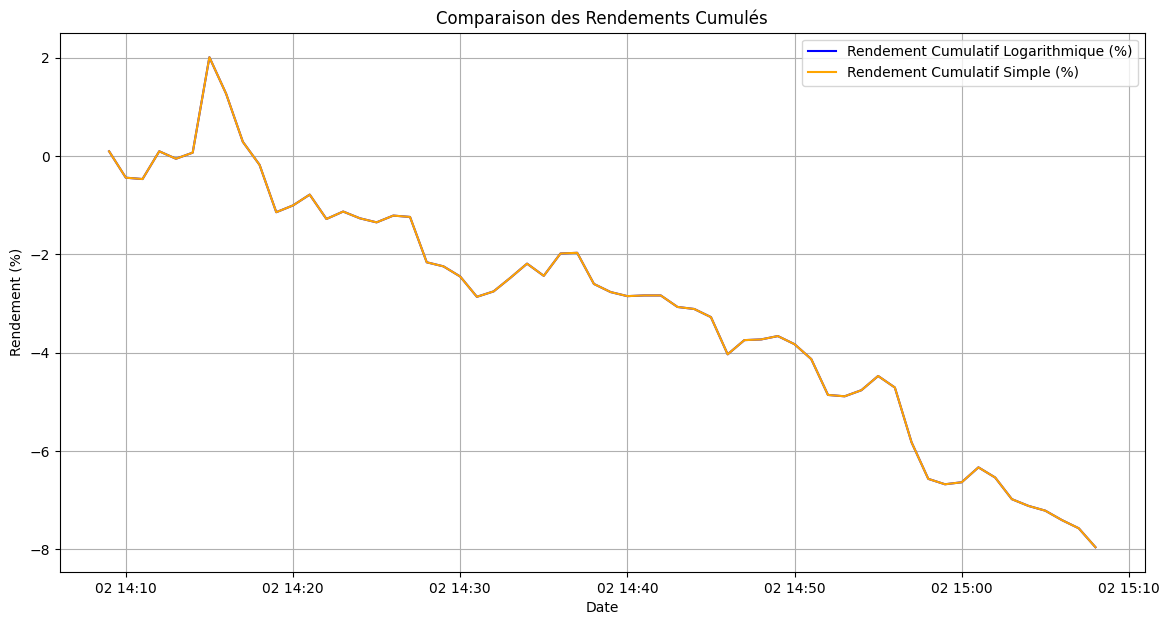

In [169]:
df_vibusdt['cumlogret'] *= 100
df_vibusdt['cumret'] *= 100

# Créer le tracé
plt.figure(figsize=(14, 7))
plt.plot(df_vibusdt.index, df_vibusdt['cumlogret'], label='Rendement Cumulatif Logarithmique (%)', color='blue')
plt.plot(df_vibusdt.index, df_vibusdt['cumret'], label='Rendement Cumulatif Simple (%)', color='orange')

# Ajouter des titres et labels
plt.title('Comparaison des Rendements Cumulés')
plt.xlabel('Date')
plt.ylabel('Rendement (%)')
plt.legend()
plt.grid()

# Afficher le graphique
plt.show()

In [151]:
# exemple avec vibusdt
df_test = pd.DataFrame(candle_data["VIBUSDT"])
# df_test["cumret"] = (df_test["close"].pct_change() + 1).prod() - 1
df_test

,close
0,
2024-11-02 14:08:00,0.07263
2024-11-02 14:09:00,0.07270
2024-11-02 14:10:00,0.07231
2024-11-02 14:11:00,0.07229
2024-11-02 14:12:00,0.07270
...,...
2024-11-02 15:04:00,0.06746
2024-11-02 15:05:00,0.06739
2024-11-02 15:06:00,0.06725


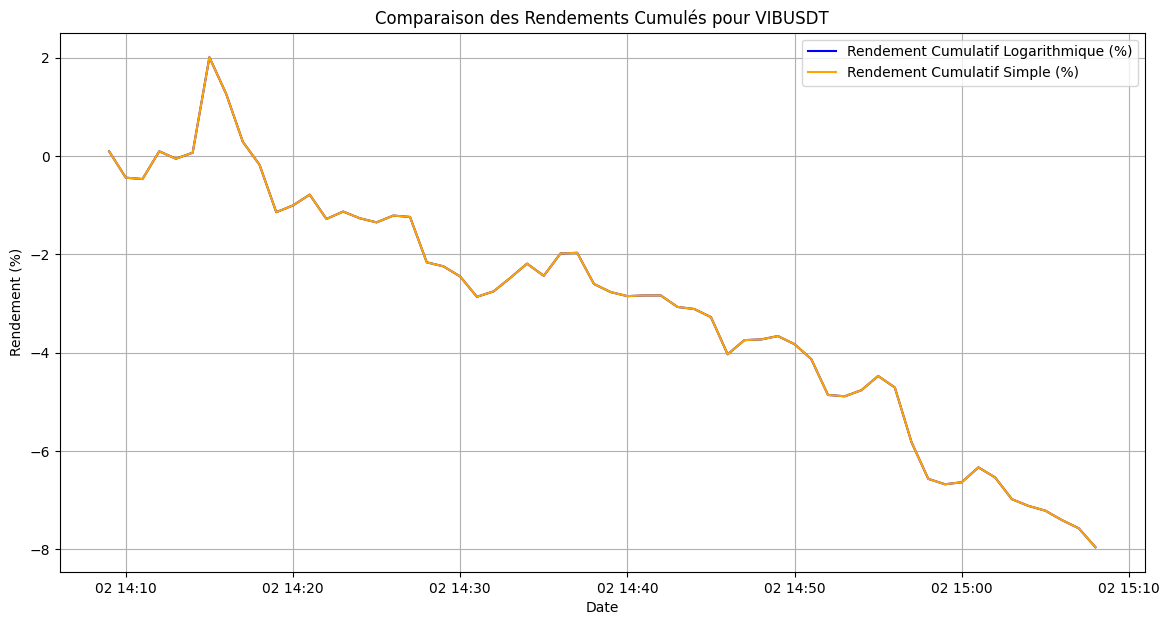

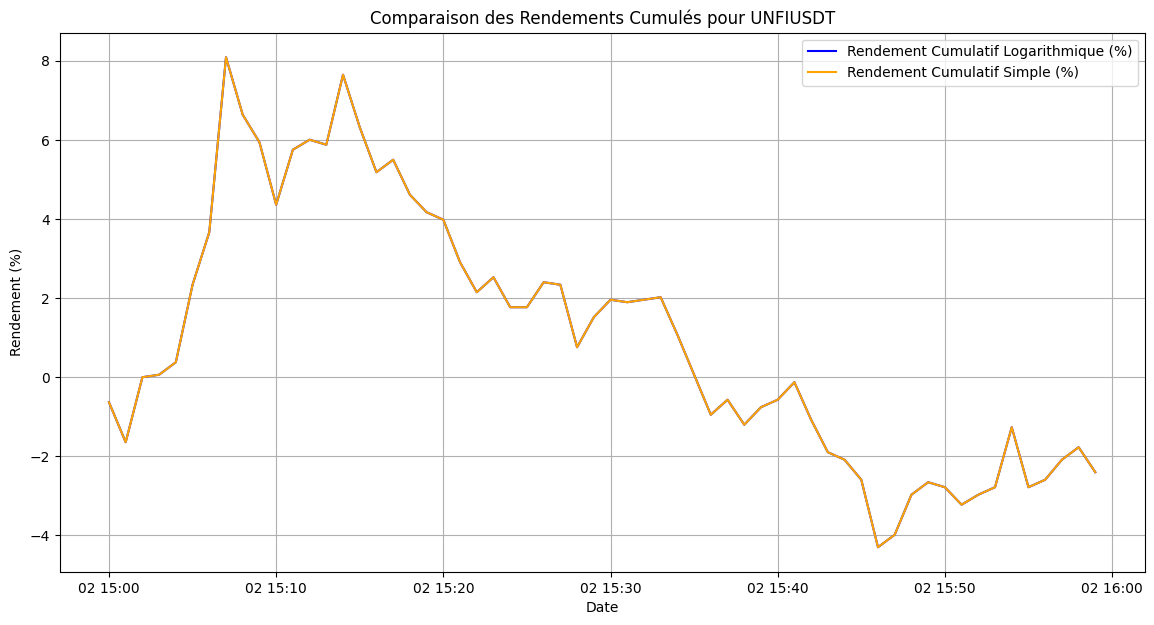

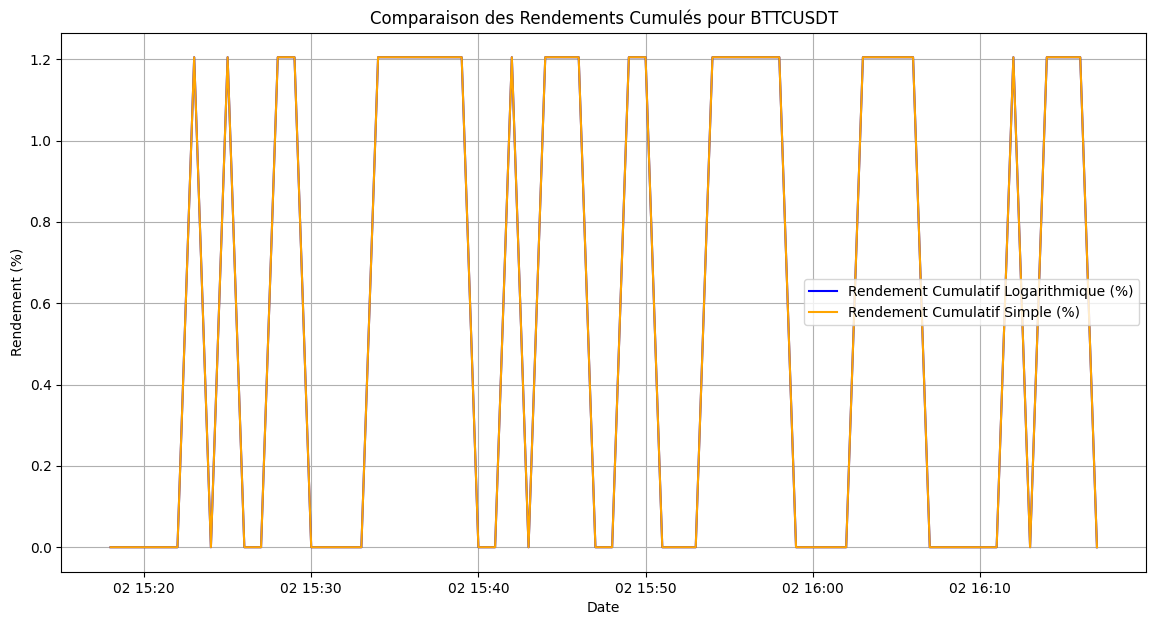

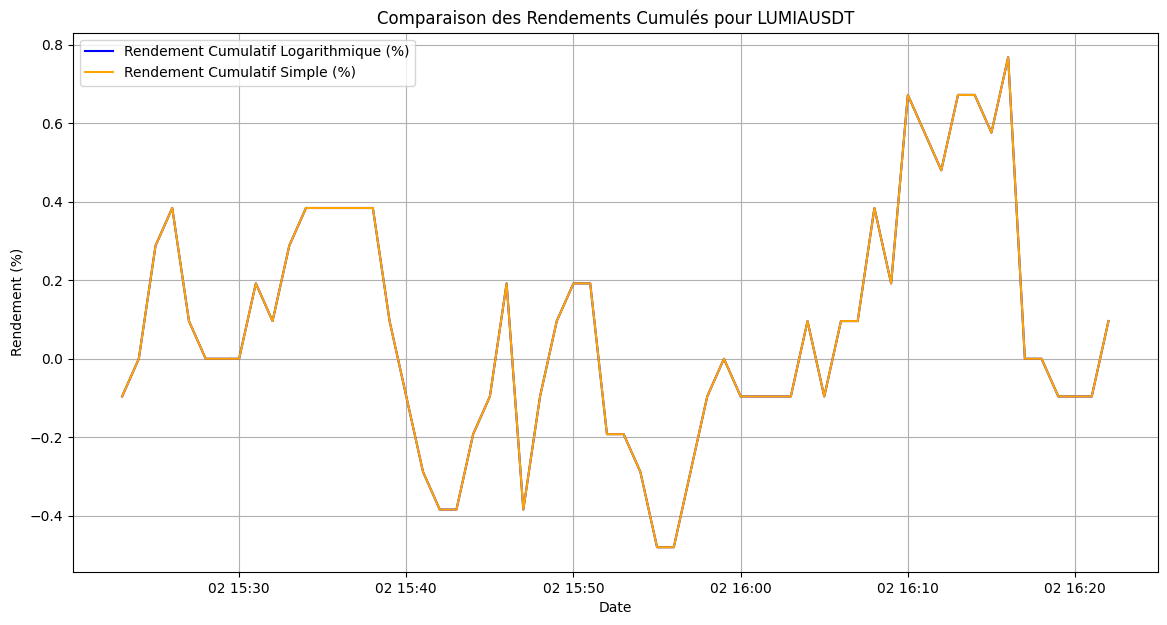

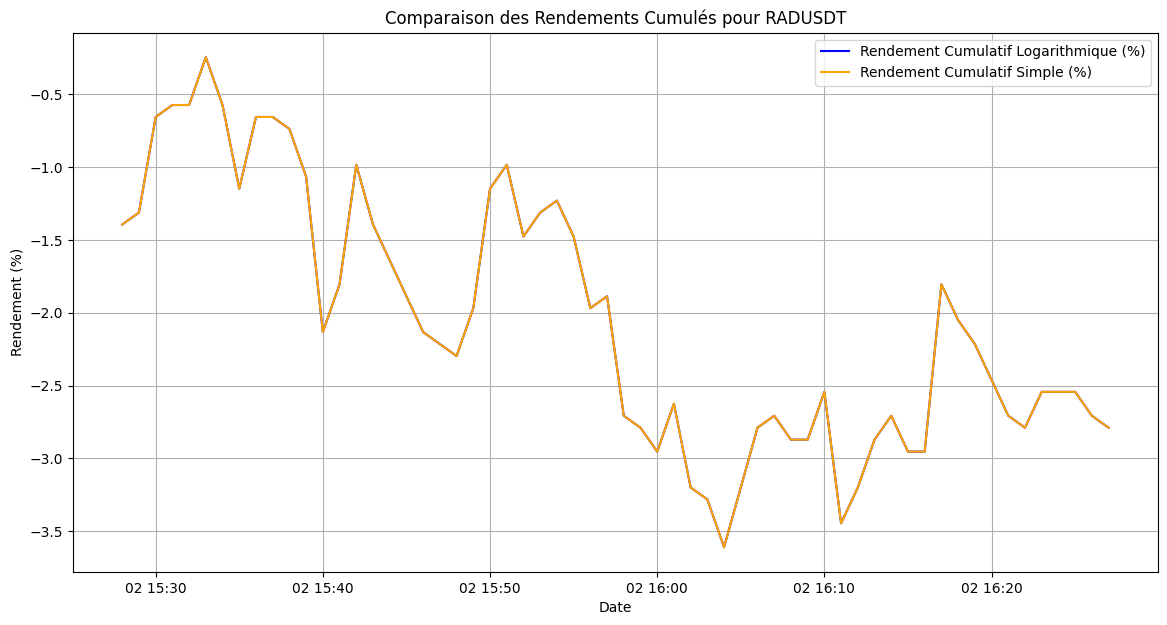

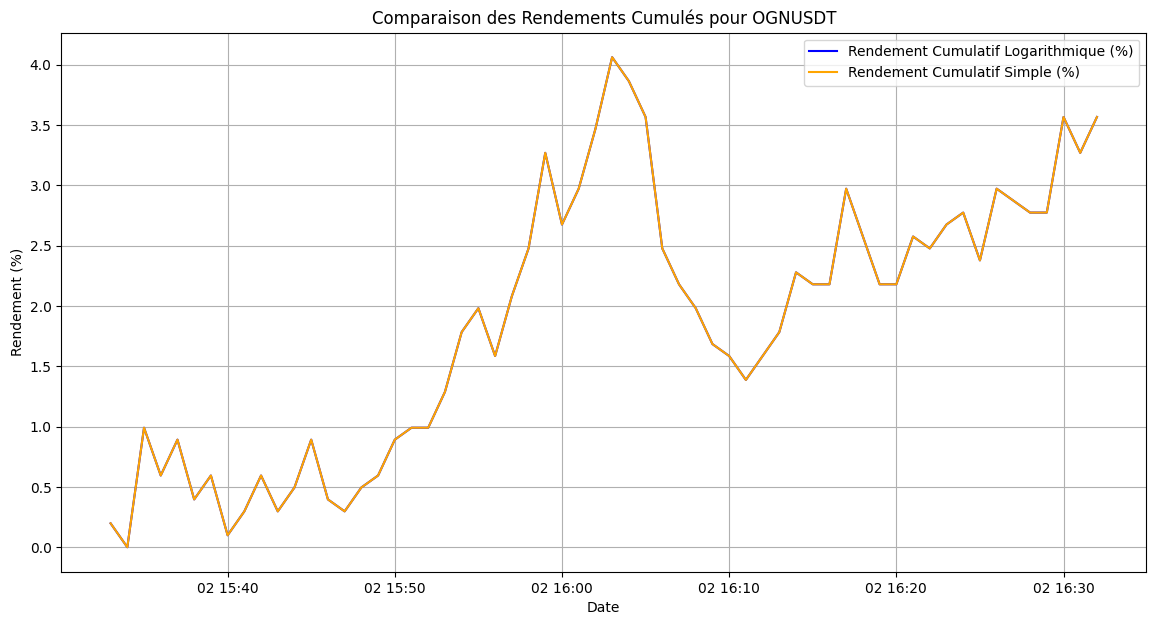

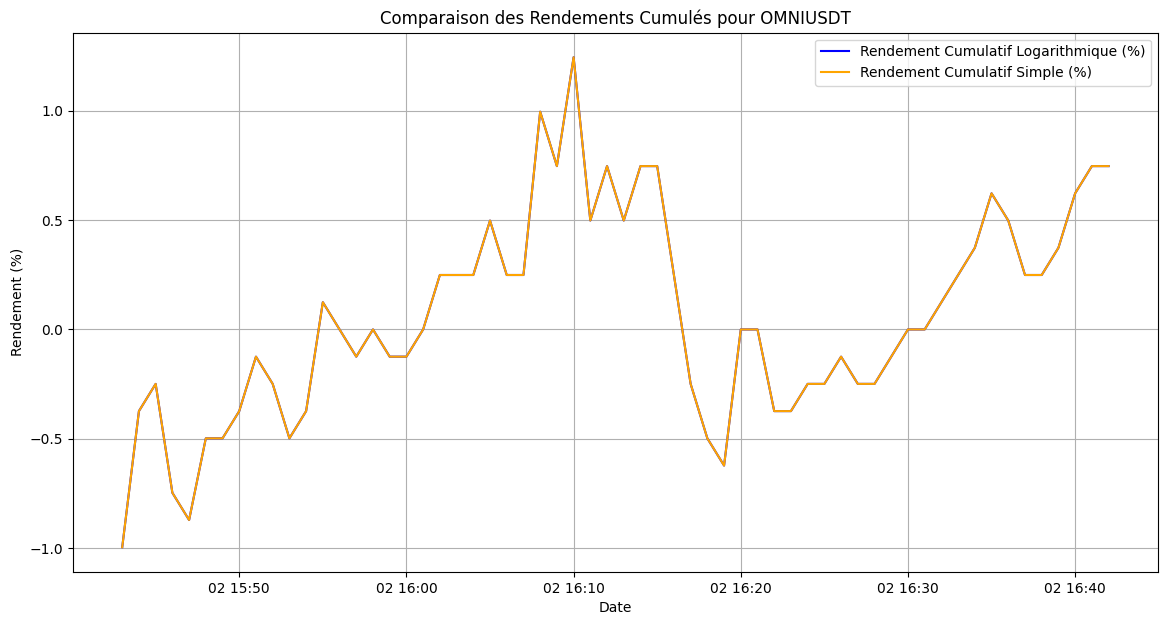

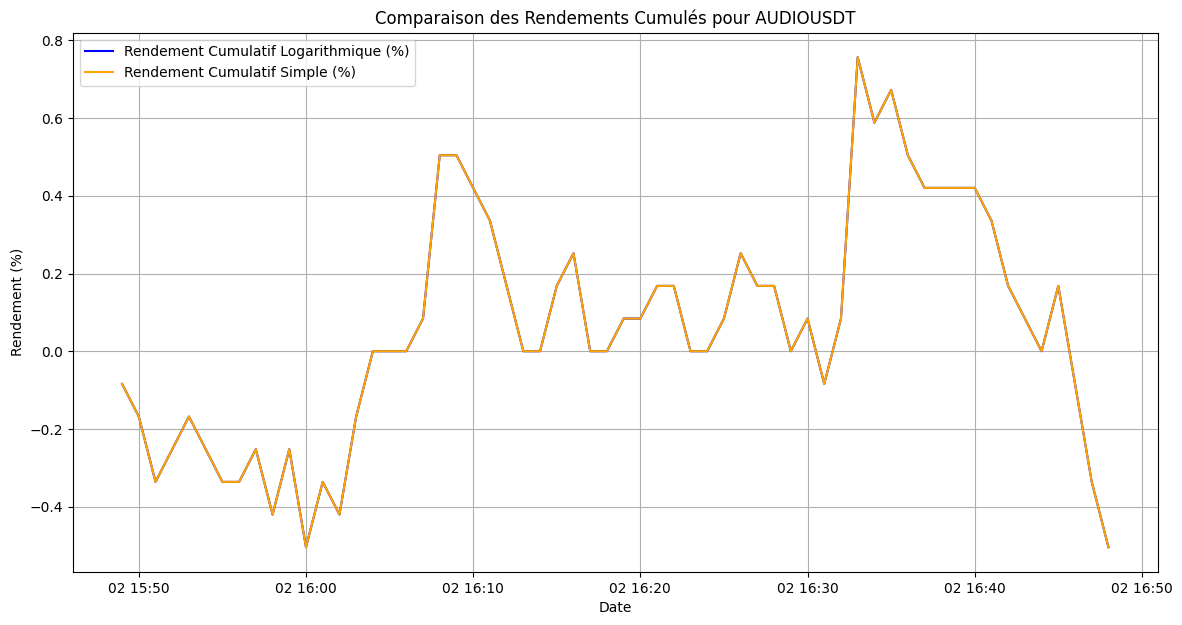

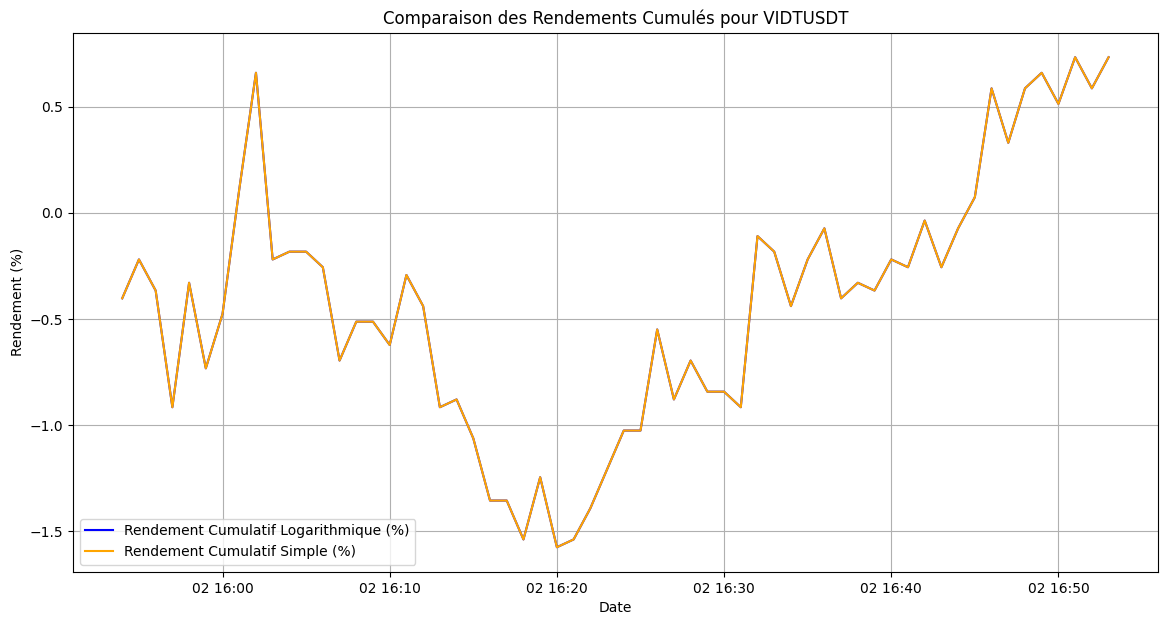

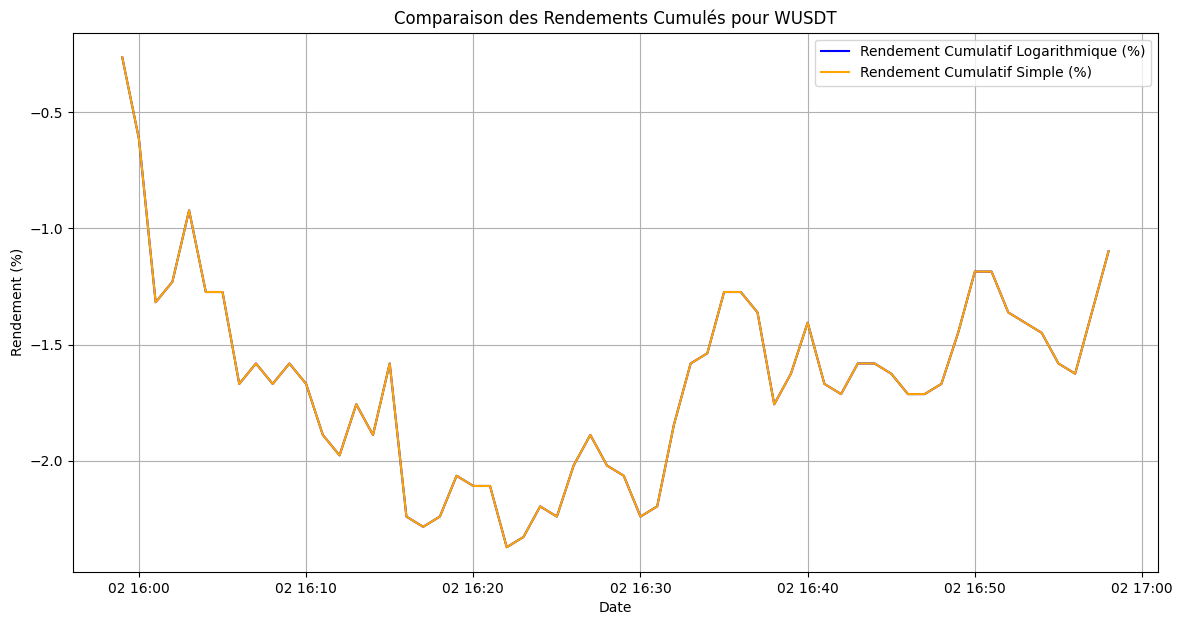

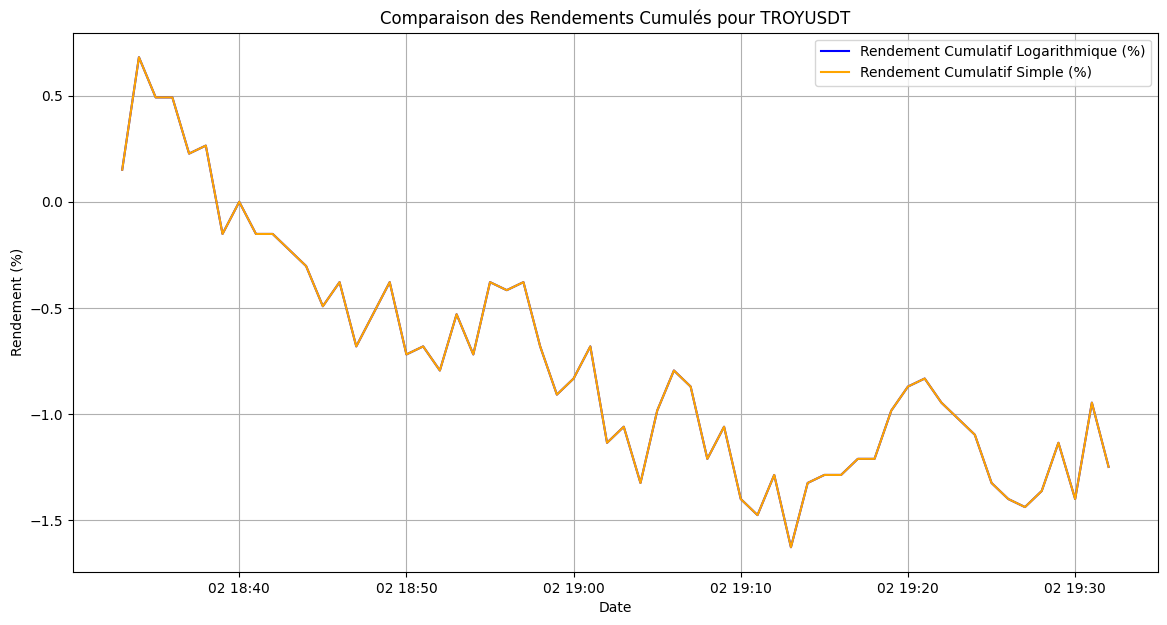

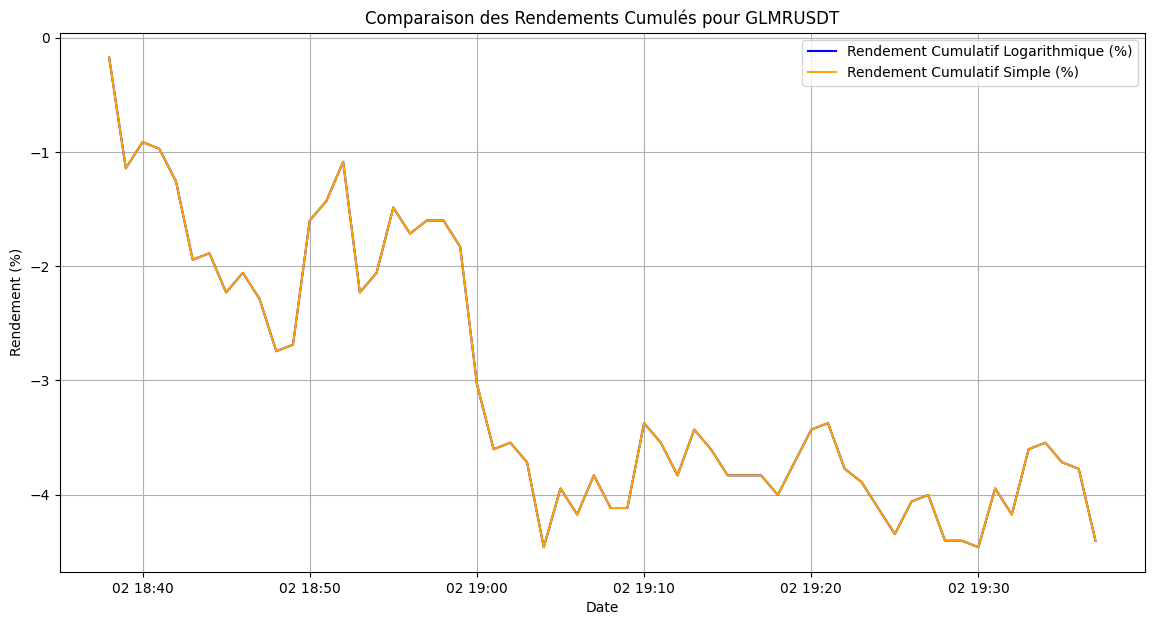

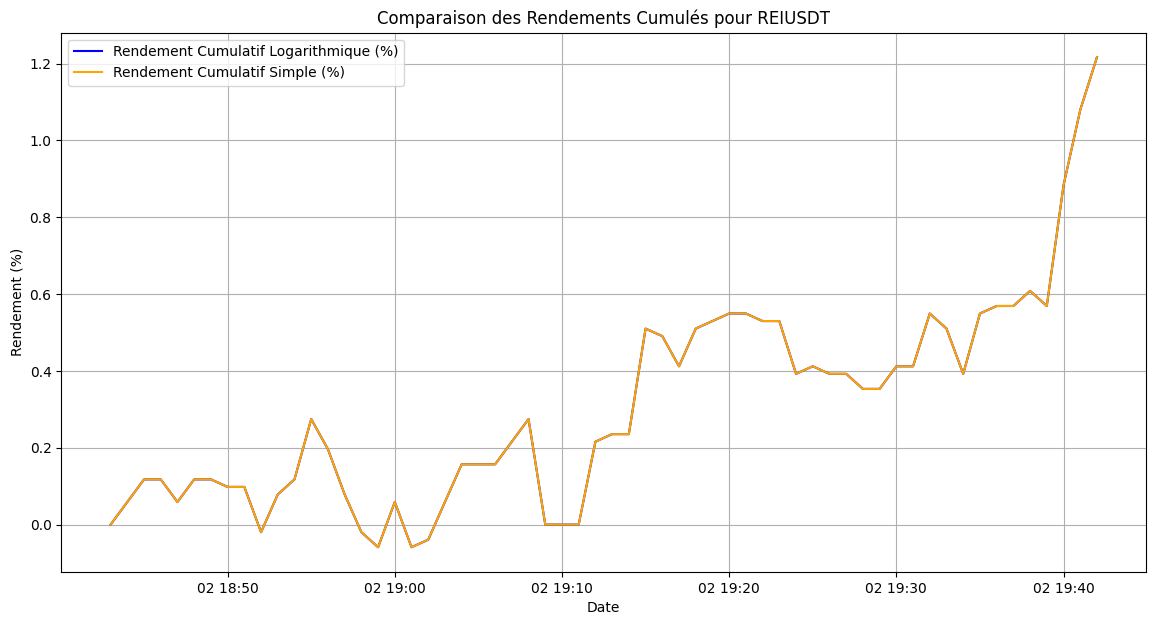

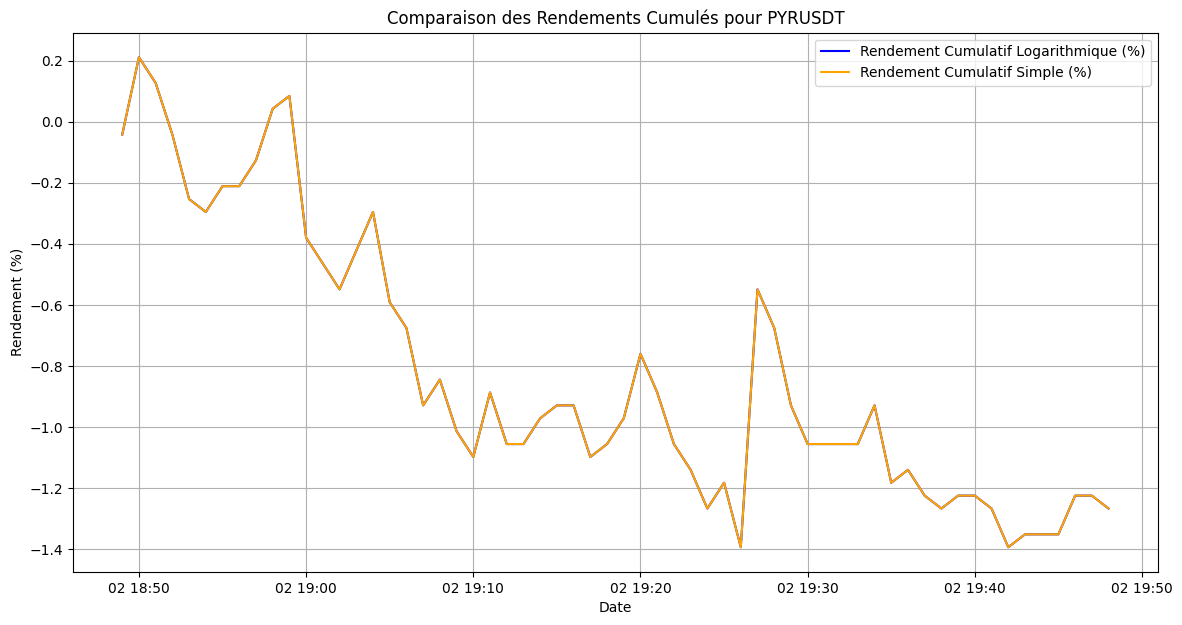

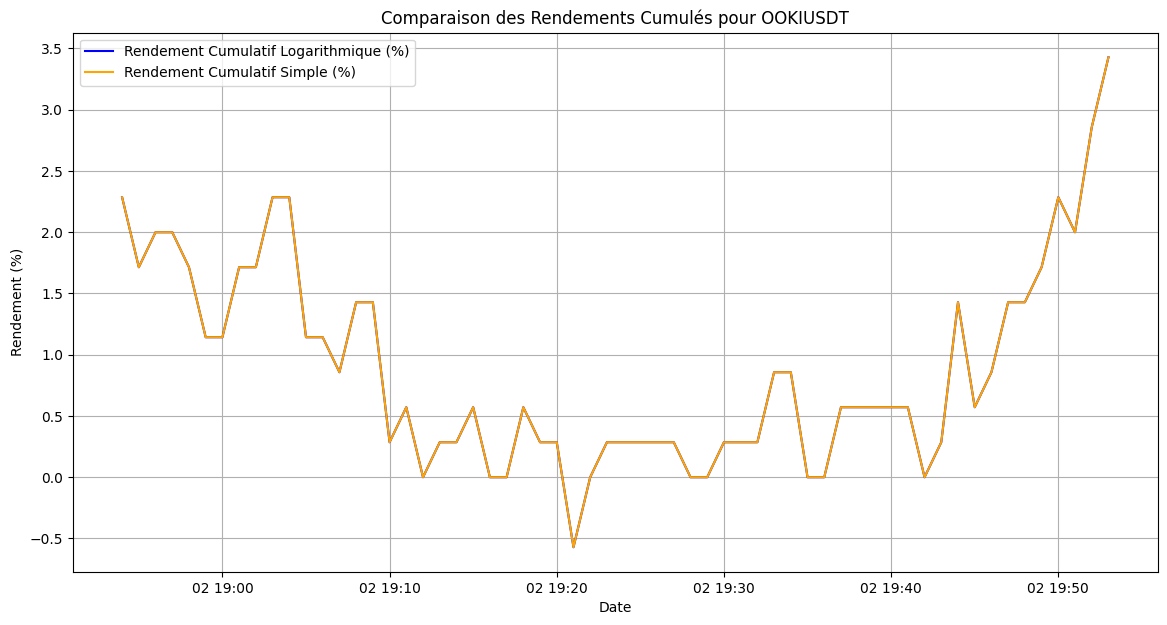

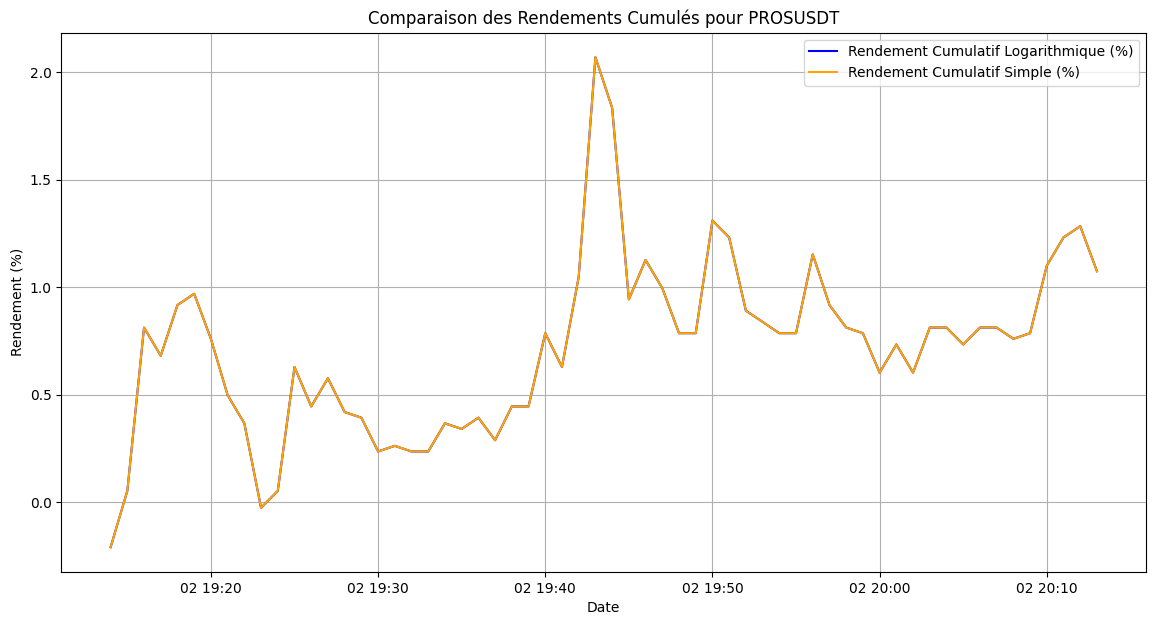

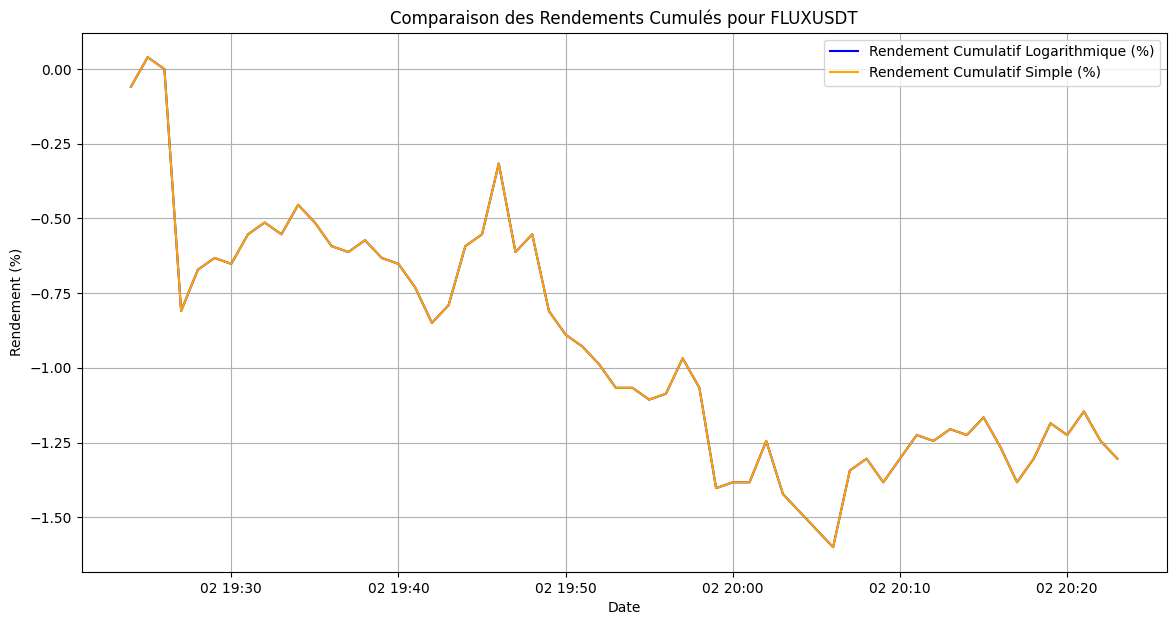

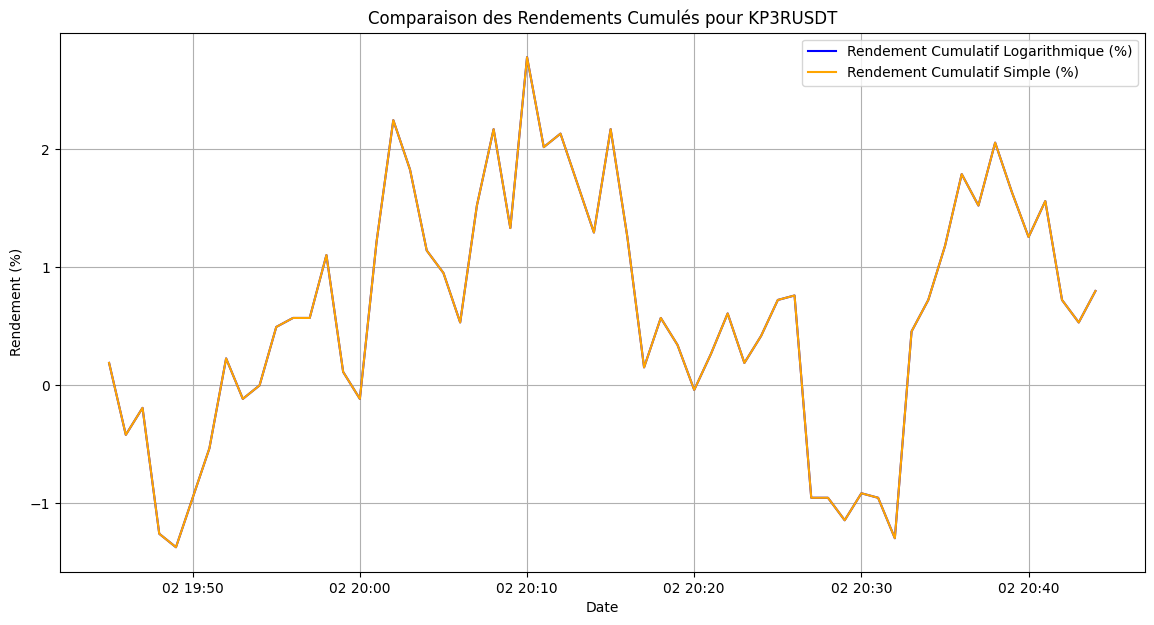

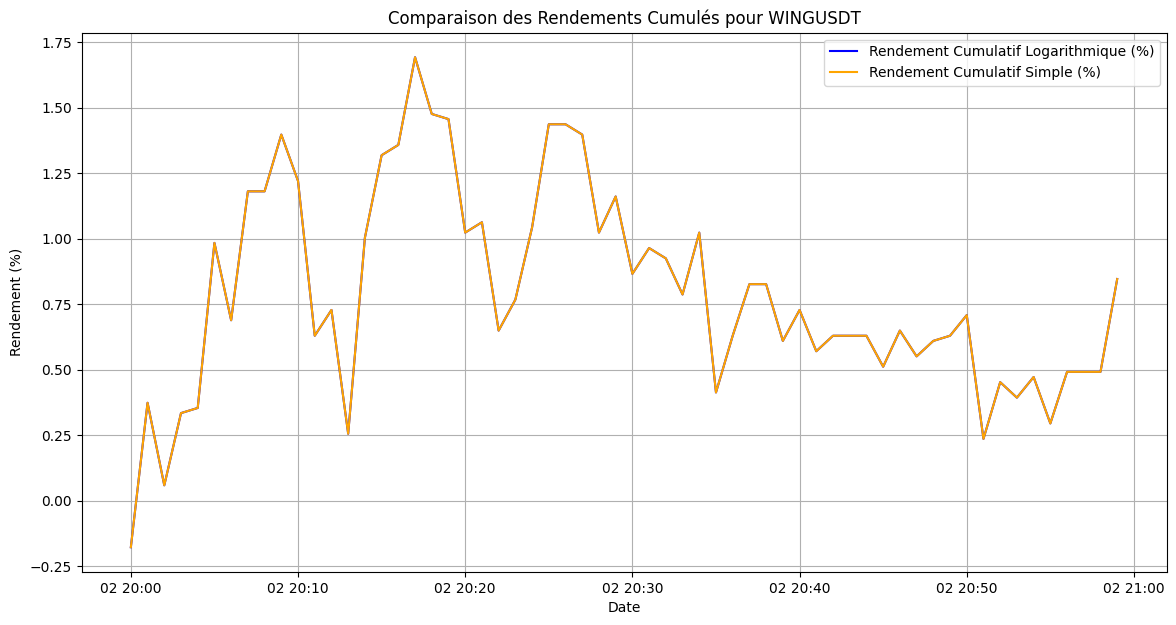

In [172]:
import numpy as np
import matplotlib.pyplot as plt

def plot_returns(candle_data, symbol):
    df = candle_data[symbol].copy()  # Crée une copie pour éviter de modifier l'original
    df['logret'] = np.log(df['close'] / df['close'].shift(1))
    
    # Calculer le rendement cumulatif logarithmique
    df['cumlogret'] = np.exp(df['logret'].cumsum()) - 1 
    df['cumlogret'] *= 100  # Conversion en pourcentage

    # Calculer le rendement simple
    df['ret'] = df['close'].pct_change()
    
    # Calculer le rendement cumulatif simple
    df['cumret'] = (1 + df['ret']).cumprod() - 1 
    df['cumret'] *= 100  # Conversion en pourcentage

    # Créer le tracé
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['cumlogret'], label='Rendement Cumulatif Logarithmique (%)', color='blue')
    plt.plot(df.index, df['cumret'], label='Rendement Cumulatif Simple (%)', color='orange')

    # Ajouter des titres et labels
    plt.title(f'Comparaison des Rendements Cumulés pour {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Rendement (%)')
    plt.legend()
    plt.grid()

    # Afficher le graphique
    plt.show()

# Appel de la fonction pour chaque symbole dans candle_data
for symbol in candle_data.keys():
    plot_returns(candle_data, symbol)


### Quelques métriques

In [180]:
def backtest_strategy(candle_data, take_profit_threshold, stop_loss_threshold):
    results = {
        'symbol': [],
        'total_return': [],
        'num_trades': [],
        'winning_trades': [],
        'losing_trades': [],
        'win_rate': [],
    }
    total_metrics = {"winning trade" : 0, "losing trade" : 0}

    for symbol, df in candle_data.items():
        initial_investment = 1  
        initial_price = df['close'].iloc[0]

        df['cumret'] = (1 + df['close'].pct_change()).cumprod() - 1

        take_profit_price = initial_price * (1 + take_profit_threshold / 100)
        stop_loss_price = initial_price * (1 - stop_loss_threshold / 100)

        trades = 0
        wins = 0
        losses = 0
        final_return = None

        for i in range(1, len(df)):
            current_price = df['close'].iloc[i]

            if current_price >= take_profit_price:
                trades += 1
                wins += 1
                final_return = take_profit_price   
                total_metrics["winning trade"]+=1
                break

            elif current_price <= stop_loss_price:
                trades += 1
                losses += 1
                final_return = stop_loss_price  
                total_metrics["losing trade"] +=1
                break

        if final_return is not None:
            total_return = (final_return - initial_price) / initial_price 
        else:
            total_return = 0        
        win_rate = wins / trades if trades > 0 else 0
        
        # Enregistrer les résultats
        results['symbol'].append(symbol)
        results['total_return'].append(total_return)
        results['num_trades'].append(trades)
        results['winning_trades'].append(wins)
        results['losing_trades'].append(losses)
        results['win_rate'].append(win_rate)

    return results, total_metrics

take_profit_threshold = 2 
stop_loss_threshold = 2  
strategy_results, total_metrics = backtest_strategy(candle_data, take_profit_threshold, stop_loss_threshold)

# for i in range(len(strategy_results['symbol'])):
#     print(f"Symbol: {strategy_results['symbol'][i]}, Total Return: {strategy_results['total_return'][i]:.2%}, "
#           f"Number of Trades: {strategy_results['num_trades'][i]}, Winning Trades: {strategy_results['winning_trades'][i]}, "
#           f"Losing Trades: {strategy_results['losing_trades'][i]}, Win Rate: {strategy_results['win_rate'][i]:.2%}")


Symbol: VIBUSDT, Total Return: 2.00%, Number of Trades: 1, Winning Trades: 1, Losing Trades: 0, Win Rate: 100.00%
Symbol: UNFIUSDT, Total Return: 2.00%, Number of Trades: 1, Winning Trades: 1, Losing Trades: 0, Win Rate: 100.00%
Symbol: BTTCUSDT, Total Return: 0.00%, Number of Trades: 0, Winning Trades: 0, Losing Trades: 0, Win Rate: 0.00%
Symbol: LUMIAUSDT, Total Return: 0.00%, Number of Trades: 0, Winning Trades: 0, Losing Trades: 0, Win Rate: 0.00%
Symbol: RADUSDT, Total Return: -2.00%, Number of Trades: 1, Winning Trades: 0, Losing Trades: 1, Win Rate: 0.00%
Symbol: OGNUSDT, Total Return: 2.00%, Number of Trades: 1, Winning Trades: 1, Losing Trades: 0, Win Rate: 100.00%
Symbol: OMNIUSDT, Total Return: 0.00%, Number of Trades: 0, Winning Trades: 0, Losing Trades: 0, Win Rate: 0.00%
Symbol: AUDIOUSDT, Total Return: 0.00%, Number of Trades: 0, Winning Trades: 0, Losing Trades: 0, Win Rate: 0.00%
Symbol: VIDTUSDT, Total Return: 0.00%, Number of Trades: 0, Winning Trades: 0, Losing Trad

In [188]:
take_profit_threshold = 2 
stop_loss_threshold = 2  
from itertools import product

values = np.linspace(0, 10, 21)
print(values)
for value in values:  # Parcours de 0 à 10
    tp = value
    sl = value
    print(f"Take Profit: {tp}, Stop Loss: {sl}")
    strategy_results, total_metrics = backtest_strategy(candle_data, tp, sl)
    print(total_metrics)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]
Take Profit: 0.0, Stop Loss: 0.0
{'winning trade': 7, 'losing trade': 12}
Take Profit: 0.5, Stop Loss: 0.5
{'winning trade': 9, 'losing trade': 10}
Take Profit: 1.0, Stop Loss: 1.0
{'winning trade': 8, 'losing trade': 9}
Take Profit: 1.5, Stop Loss: 1.5
{'winning trade': 6, 'losing trade': 7}
Take Profit: 2.0, Stop Loss: 2.0
{'winning trade': 6, 'losing trade': 3}
Take Profit: 2.5, Stop Loss: 2.5
{'winning trade': 4, 'losing trade': 3}
Take Profit: 3.0, Stop Loss: 3.0
{'winning trade': 3, 'losing trade': 3}
Take Profit: 3.5, Stop Loss: 3.5
{'winning trade': 2, 'losing trade': 3}
Take Profit: 4.0, Stop Loss: 4.0
{'winning trade': 2, 'losing trade': 2}
Take Profit: 4.5, Stop Loss: 4.5
{'winning trade': 1, 'losing trade': 1}
Take Profit: 5.0, Stop Loss: 5.0
{'winning trade': 1, 'losing trade': 1}
Take Profit: 5.5, Stop Loss: 5.5
{'winning trade': 1, 'losing trade': 1}
Take Profit: 6